In [96]:
from numba import cuda, float32, njit
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns
import math
import operator
import time
from PIL import Image
import cv2

In [2]:
def get_rotatation(u, theta):
    C = np.zeros((3,3))
    C[1,1] = -u[2]
    C[1,0] = u[2]
    C[1,2] = -u[0]
    C[2,0] = -u[1]
    C[2,1] = u[0]
    return np.identity(3) + C*math.sin(theta) + C*C * (1-math.cos(theta))
# https://stackoverflow.com/questions/6802577/rotation-of-3d-vector
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
def coord_to_point(x,y,n):
    x_ = math.pi*x/n
    y_ = 2*math.pi*y/n-math.pi
    return np.array([math.sin(x_)*math.cos(y_), math.sin(x_)*math.sin(y_), math.cos(x_)])
def filter_points(points, n):
    return [(x_,y_%n) for x_,y_ in points if 0 <= x_ <= n-1]
def get_neighours(x,y,n, k):
    points = [(x+k,y),(x-k, y), 
             (x, (y+k)%n), (x,(y-k)%n)]
    return [(x_,y_) for x_,y_ in points if 0 <= x_ <= n-1]

# Heat Equation for Planet Warming 

$$ \frac{\partial U}{\partial t} = \frac{k}{(r sin \theta)^2} \frac{\partial^2 U}{\partial \phi^2} + \frac{k}{r^2} cot \theta \frac{\partial U}{\partial \theta} + \frac{k}{r^2} \frac{\partial^2 U}{\partial \theta^2} + \alpha (\theta, \phi) \left ( \beta \textbf{P} \cdot R \textbf{n}(\theta,\phi) - U \right ) - \lambda U $$

In [65]:
def solve_heat(U_0, u, k=2, b=1, l=0.5, zeta=300, alpha=1, t=300, dt=0.0001, iterations=100):
    U = np.copy(U_0)
    curve = [U_0]
    t_ = 0
    m = len(U)
    h = 2*math.pi/m
    print(dt/h**2)
    for _ in range(iterations):
        U_next = np.zeros(U.shape)
        p = np.array([math.cos(zeta*t_), math.sin(zeta*t_), 0])
        R = rotation_matrix(u, alpha*t_)
        for i in range(5,m-5):
            x = math.pi*i/m
            r = dt/((math.sin(x)*h/2)**2)
            if r >= 1/2:
                raise Exception(r)
            for j in range(m):
                y = 2*math.pi*j/m-math.pi
                
                # compute normal vector
                n = coord_to_point(i,j,len(U))
                rotated_n = np.dot(R, n)
                d2dphi = (U[i,(j-1)%m]+U[i,(j+1)%m]-2*U[i,j])/((math.sin(x)*h)**2) 
                
                if i+1 >= m:
                    # backwards difference
                    dUdtheta = (U[i,j]-U[i-2,j])/(h/2)
                elif i-1 < 0:
                    # forward difference
                    dUdtheta = (U[i+2,j]-U[i,j])/(h/2)
                else:
                    # central difference
                    dUdtheta = (U[i+1,j]-U[i-1,j])/(h/2)

                if i+2 >= m:
                    # backward difference
                    dU_2dtheta_2 = (U[i,j]-2*U[i-2,j]+U[i-4,j])/((h/2)**2)
                elif i-2 < 0:
                    # forward difference
                    dU_2dtheta_2 = (U[i+4,j]-2*U[i+2,j]+U[i,j])/((h/2)**2)
                else:
                    # central difference
                    dU_2dtheta_2 = (U[i+2,j]+U[i-2,j]-2*U[i,j])/((h/2)**2) 
                    
                cot = 1/math.tan(x)
                theta_bit = cot*dUdtheta + dU_2dtheta_2
                
                part1 = d2dphi+theta_bit
                
                dot = np.dot(p, rotated_n)
                light = b*abs(dot) if dot <= 0 else 0
                U_next[i,j] = U[i,j]+0*part1*dt + (light-U[i,j])*dt - l*U[i,j]*dt
        t_ += dt
        U = np.copy(U_next)
        #curve.append(U_next)
    return U,curve

# Cuda Implementation

60
17.41264033317566 0
0.005787034999992831 345 144.67587499982076


<Axes: >

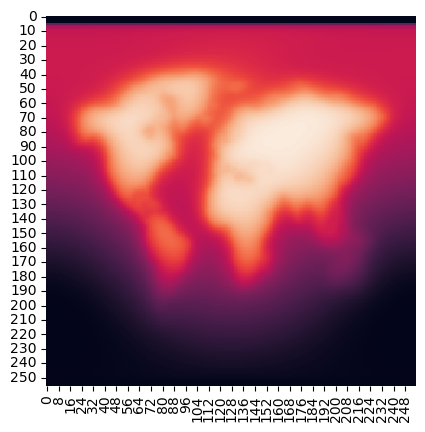

In [102]:
@cuda.jit
def update_heat(U, U_next, alpha_mat, normals, rotated_n, b, p, R, k, l, dt, m, I):
    m = U.shape[0]
    pos = cuda.threadIdx.x+cuda.blockIdx.x*cuda.blockDim.x
    if pos >= m*m:
        return
    h = 2*math.pi/m
    i = pos % m
    j = pos // m
    if i >= m or j >= m:
        return 
    if i < I or i > m-I:
        U_next[i,j] = 0
        return
    x = math.pi*i/m
    # compute normal vector
    for i1 in range(3):
        s = 0
        for k1 in range(3):
            s += R[k1,i1]*normals[i,j,k1]
        rotated_n[i,j,i1] = s
    d2dphi = (U[i,(j-1)%m]+U[i,(j+1)%m]-2*U[i,j])/((math.sin(x)*h)**2) 

    # central difference
    dUdtheta = (U[i+1,j]-U[i-1,j])/h

    # central difference
    dU_2dtheta_2 = (U[i-1,j]+U[i+1,j]-2*U[i,j])/(h**2) 
        
    cot = 1/math.tan(x)
    theta_bit = cot*dUdtheta + dU_2dtheta_2
    
    part1 = d2dphi+theta_bit
    
    dot = p[0]*rotated_n[i,j,0]+p[1]*rotated_n[i,j,1]+p[2]*rotated_n[i,j,2]
    light = b*abs(dot) if dot <= 0 else 0
    U_next[i,j] = U[i,j] + k*part1*dt + alpha_mat[i,j]*(light-U[i,j])*dt - l*U[i,j]*dt\


@cuda.jit 
def temp_to_rgb(U, U_col, colour, max):  
    index = cuda.grid(1) 
    m = len(U)
    if index >= m*m:
        return 
    i = pos % m
    j = pos // m
    U_col[i,j] = (U[i,j]/max) * colour

N = 256
theta = math.pi/2-0.408407

start = time.time()

u = np.array([math.cos(theta),0, math.sin(theta)])
U = cuda.to_device(np.zeros((N,N)))
U_next = cuda.to_device(np.zeros((N,N)))
normals = np.zeros((N,N,3)) 
for x in range(N):
    for y in range(N):
        p = coord_to_point(x,y,N)
        for i,v in enumerate(p):
            normals[x,y,i] = v
normals_cuda = cuda.to_device(normals)
rotated_n = cuda.device_array_like(normals_cuda)

# compute alpha(theta,phi) from image 
im = Image.open('map.jpg')
new_image = im.resize((N,N))
pix = new_image.load()

alpha_mat = np.zeros(new_image.size)
for i in range(N):
    for j in range(N):
        alpha_mat[i,j] = min(np.linalg.norm(255*np.ones(3)-pix[j,i])+0.5, 1) # between [0.5,1.5]
alpha_mat_cuda = cuda.to_device(alpha_mat)

t_ = 0
zeta = 10*2500
curve = [U]
counter = 0
dt = 1000 * 0.0000000001157407 # = 1000 * 1/86400 days = 1000 seconds 

p = np.array([-1,0,0]) 
p = cuda.to_device(p)
R_ = rotation_matrix(u, zeta*t_)
R = cuda.to_device(R_)
b = 0.5
k = 5
l = 0.5
matrix_update = max(60, math.floor(math.pi/(180*dt*zeta)))
print(matrix_update)
for i in range(50000):
    if i%matrix_update == 0:
        R_ = rotation_matrix(u, zeta*t_)
        R = cuda.to_device(R_)
    update_heat[256,256](U, U_next, alpha_mat_cuda, normals_cuda, rotated_n, b, p, R, k, l, dt, N, 5)
    cuda.synchronize()
    U,U_next = U_next,U
    t_ += dt
    counter += dt
    if int(1000*60*counter) >= 1:
        curve.append(U.copy_to_host())
        counter = 0
end = time.time()
print(end-start, times)
print(t_, len(curve), zeta*t_)
U_n = U.copy_to_host()
sns.heatmap(U_n, vmin=0, vmax=np.max(U_n), square=True, cbar=False)

345


file name? : map


MovieWriter stderr:
map.mp4: Permission denied



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x800', '-pix_fmt', 'rgba', '-framerate', '5', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'map.mp4']' returned non-zero exit status 1.

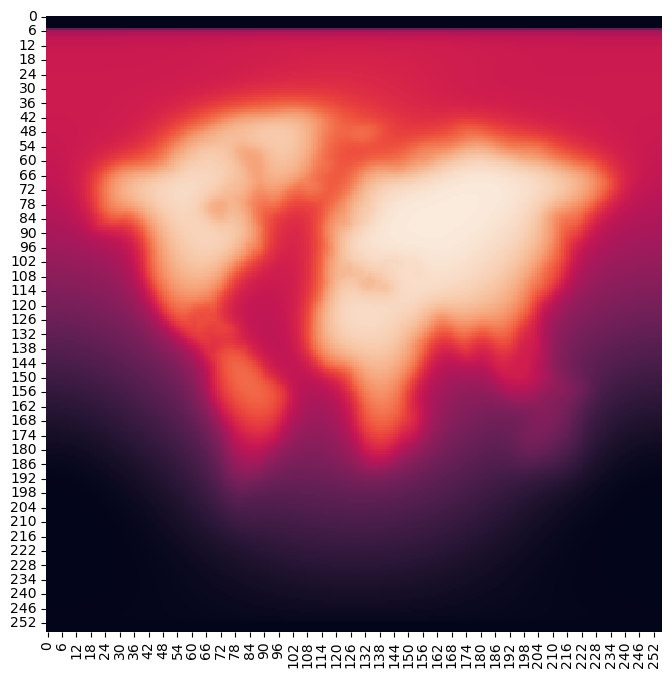

In [103]:
fig = plt.figure(figsize=(10,8))
max_temp = np.max(U_n)
def init():
    ax = sns.heatmap(U, vmin=0, vmax=max_temp, square=True, cbar=False)
def update(frame):
    data = curve[frame]
    ax = sns.heatmap(data, vmin=0, vmax=max_temp, square=True, cbar=False)
 
anim = animation.FuncAnimation(fig, update, init_func=init, frames=len(curve), repeat = False)
print(len(curve))
FFwriter = animation.FFMpegWriter()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800//16)
anim.save(f'{input("file name? :")}.mp4', writer=FFwriter)

"""
savefile = f"{input("file name: ?")}.gif"
pillowwriter = animation.PillowWriter(fps=5)
anim.save(savefile, writer=pillowwriter,dpi=80)
"""

In [99]:
out = cv2.VideoWriter('map.mp4',cv2.VideoWriter_fourcc(*'DIVX'),15, (96,96))

for i in range(len(curve)):
    rgb_img = cv2.cvtColor(curve[i], cv2.COLOR_RGB2BGR)
    out.write(rgb_img)
out.release()

error: OpenCV(4.10.0) C:\b\abs_daut97tdpo\croot\opencv-suite_1722029138522\work\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<1,-1,-1>,struct cv::impl::A0xaa65d054::Set<3,4,-1>,struct cv::impl::A0xaa65d054::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [10]:
U = np.zeros((50,50))
theta = math.pi/2-0.408407
u = np.array([math.cos(theta),0, math.sin(theta)])

In [107]:
s = time.time()
U_n,curve = solve_heat(U, u, b=0.5, k=1, l=0.05, zeta=0, alpha=0, t=0.25, dt= 0.0000000001, iterations=1)
e = time.time()
print(e-s)

2.6560740364736995e-06
12.0899977684021


file name: ? gpu.mp4


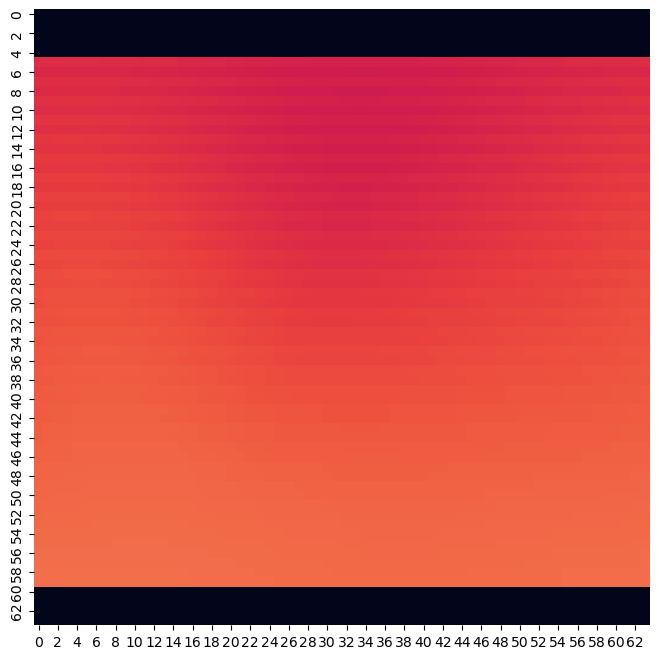

In [89]:
fig = plt.figure(figsize=(10,8))
def init():
    ax = sns.heatmap(U, vmin=0, vmax=0.1, square=True, cbar=False)
def update(frame):
    data = curve[frame]
    ax = sns.heatmap(data, vmin=0, vmax=0.1, square=True, cbar=False)
 
anim = animation.FuncAnimation(fig, update, init_func=init, frames=len(curve), repeat = False)
savefile = f"{input("file name: ?")}.gif"
pillowwriter = animation.PillowWriter(fps=10)
anim.save(savefile, writer=pillowwriter,dpi=80)

plt.show()

In [117]:
def light(u, p,alpha, n, total_t=25, iterations=1000):
    curve = []
    t = 0
    for _ in range(iterations):
        U = np.zeros((n,n))
        R = rotation_matrix(u, alpha*t)
        for x in range(n):
            for y in range(n):
                normal = coord_to_point(x,y,n)
                rotated_n = np.dot(R, normal)
                dot = np.dot(p, rotated_n)
                light = abs(dot) if dot <= 0 else 0
                U[x,y] = light
        curve.append(U)
        t += total_t/iterations
    return curve
        

In [118]:
curve = light(u, np.array([1,0,0]), 1/2, 50,50, 500)

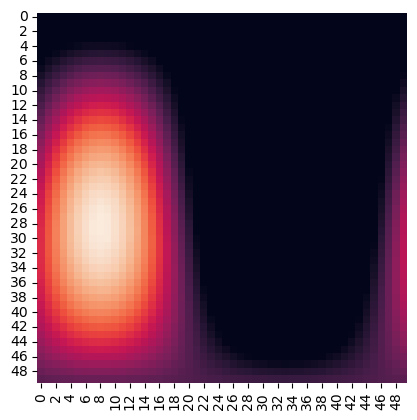

In [119]:
fig = plt.figure()
#ax.imshow(U_n, cmap='hot', interpolation='nearest')
def init():
    ax = sns.heatmap(U, vmin=0, vmax=1, square=True, cbar=False)
def update(frame):
    data = curve[20*frame]
    ax = sns.heatmap(data, vmin=0, vmax=1, square=True, cbar=False)

anim = animation.FuncAnimation(fig, update, init_func=init, frames=len(curve)//20, repeat = False)
savefile = r"light.gif"
pillowwriter = animation.PillowWriter(fps=2)
anim.save(savefile, writer=pillowwriter)

plt.show()

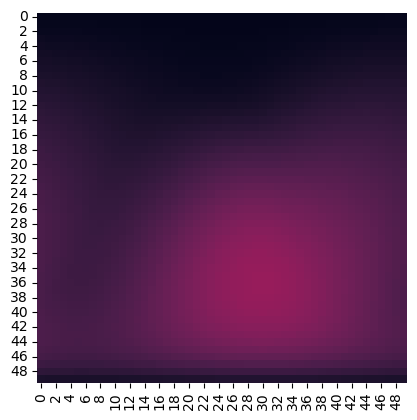

In [131]:
pillowwriter = animation.PillowWriter(fps=10)
anim.save(savefile, writer=pillowwriter,dpi=200)

<Axes: >

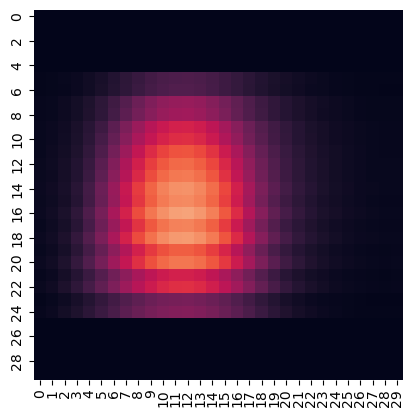

In [116]:
sns.heatmap(U_n, vmin=0, vmax=0.2, square=True, cbar=False)

In [8]:
from PIL import Image
im = Image.open('map.png') # Can be many different formats.
pix = im.load()

In [12]:
print(im.size)

(1536, 864)
